# Analysis of NIST Ground dataset (detailed version)

This notebook uses PVPRO to analyze the NIST dataset.

The NIST dataset is publicly available here: https://pvdata.nist.gov/




In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from ipywidgets import interact
from pvlib.pvsystem import retrieve_sam


from pvpro import PvProHandler
from pvpro.preprocess import Preprocessor
from pvpro.plotting import PvProPlot
from pvpro.postprocess import PostProcessor
from pvpro.plotting import plot_post_processed_results

# Load data

In [2]:
# Require the download of NIST-ground dataset from:
# https://datahub.duramat.org/dataset/752151f8-7ba3-486e-954c-0126227f89b5/resource/e40a91f9-fa84-4a2b-b6d8-312c15fc761b/download/nist01_onemin-ground.pkl
sys_name = 'NIST_ground'
dfi = pd.read_pickle('examples/data/nist01_onemin-Ground.pkl')
df = dfi[::20]  # downsample to 20 min

In [3]:
modules_per_string = 12
parallel_strings = 96
voltage_dc_key = 'InvVDCin_Avg'
current_dc_key = 'InvIDCin_Avg'
temperature_module_key= 'RTD_C_Avg_4'
irradiance_poa_key = 'RefCell1_Wm2_Avg'
cells_in_series = 60
alpha_isc = 0.053e-2*8.6 # units of A/C
delta_T = 3
technology = 'mono-Si'
module = retrieve_sam('CECmod')['Sharp_NU_U235F2']

# Preprocess

In [4]:
pre = Preprocessor(
                   voltage_dc_key = voltage_dc_key,
                   current_dc_key = current_dc_key,
                   temperature_module_key = temperature_module_key,
                   irradiance_poa_key = irradiance_poa_key,
                   modules_per_string = modules_per_string,
                   parallel_strings = parallel_strings,
                   techonology = technology,
                   alpha_isc = alpha_isc,
                   cells_in_series = cells_in_series
                   )

In [5]:
df_pro, dh = pre.run_basic_preprocess(df) 

Fixing daylight savings time shift...
Running solar data tools...


/Users/baojie/opt/miniconda3/lib/python3.9/site-packages/solardatatools/time_axis_manipulation.py:205: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  delta, count = mode(diff[fltr])
/Users/baojie/opt/miniconda3/lib/python3.9/site-packages/solardatatools/data_quality.py:60: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Se

total time: 4.56 seconds
--------------------------------
Breakdown
--------------------------------
Preprocessing              0.82s
Cleaning                   2.20s
Filtering/Summarizing      1.54s
    Data quality           0.09s
    Clear day detect       0.15s
    Clipping detect        0.86s
    Capacity change detect 0.44s
Extra Column Processing    0.00s


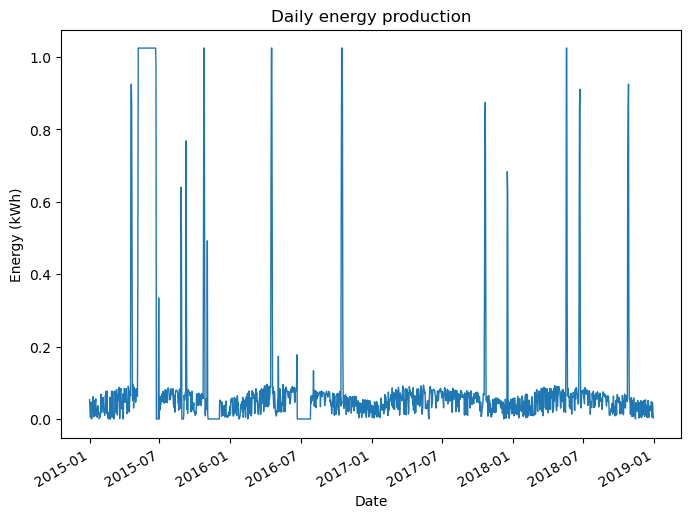

In [6]:
fig = dh.plot_daily_energy()

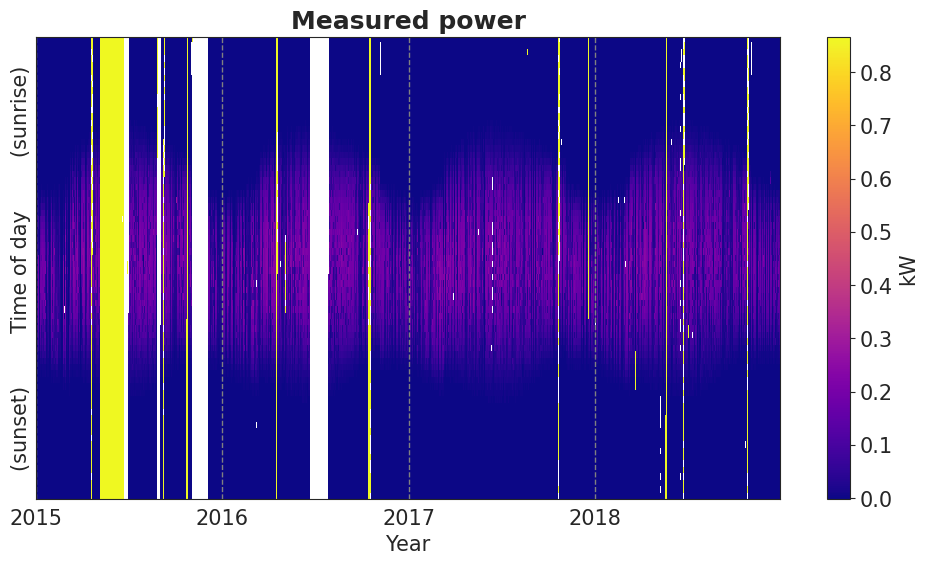

In [7]:
fig = dh.plot_heatmap()

/Users/baojie/Library/CloudStorage/OneDrive-stu.xjtu.edu.cn/LBL_study/Git_PVPRO/pvpro_master/pvpro/pvpro/plotting.py:669: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels(['','Anomaly','Inverter off','MPP', 'Open circuit', 'Clipped'])


<Figure size 1200x600 with 0 Axes>

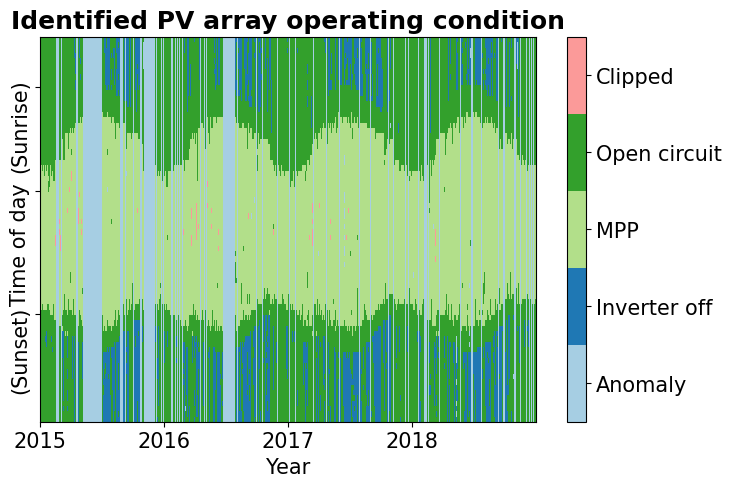

In [8]:
pvproplot = PvProPlot() 
fig = pvproplot.plot_operating_condition(dh.extra_matrices)

In [9]:
df_pro['current_irradiance_outliers'], filter_IG_info = pre.find_current_irradiance_outliers(
                                                    df_pro, points_per_iteration=5000, epsilon=2)

In [10]:
max_k = len(filter_IG_info['upper_iter_idx'])
@interact
def show_inbounds_IE(k=(0,max_k,1)):

    k = round(k)
    poa = df_pro[pre.irradiance_poa_key]
    current = df_pro[pre.current_dc_key]/pre.parallel_strings
    cax = np.arange(filter_IG_info['lower_iter_idx'][k], filter_IG_info['upper_iter_idx'][k]).astype('int')

    inbounds =  np.logical_and(np.logical_not(filter_IG_info['outliers'][cax]), filter_IG_info['boolean_mask'][cax])
    outliers =  np.logical_and(filter_IG_info['outliers'][cax],filter_IG_info['boolean_mask'][cax])
    
    x_smooth = np.linspace(0,1200,5)
    fig = plt.figure()
    plt.scatter(poa[cax][inbounds],current[cax][inbounds],s=1,c='b',label='Points to use')
    plt.plot(x_smooth, filter_IG_info['huber'][k].coef_ * x_smooth + filter_IG_info['huber'][k].intercept_,'g')

    plt.scatter(poa[cax][outliers], current[cax][outliers], s=1,
               c='r',label='Outliers')
    plt.xlabel('POA (W/m^2)')
    plt.ylabel('Current (A)')
    plt.xlim([0,1200])
    plt.ylim([0,11])
    plt.legend()
    plt.show()

interactive(children=(IntSlider(value=9, description='k', max=19), Output()), _dom_classes=('widget-interact',…

In [11]:
df_pro['voltage_temperature_outliers'], filter_VT_info= pre.find_temperature_voltage_outliers(df_pro, 
                                                voltage_lower_lim=0,
                                                  poa_lower_lim=200,
                                                  points_per_iteration=5000,
                                                 epsilon=2) 

In [12]:
max_k = len(filter_VT_info['upper_iter_idx'])
@interact
def show_inbounds_TV(k=(0,max_k,1)):
    k = round(k)
    poa = df_pro[pre.irradiance_poa_key]
    current = df_pro[pre.current_dc_key]/pre.parallel_strings
    voltage = df_pro[pre.voltage_dc_key]/pre.modules_per_string
    temperature_cell = df_pro['temperature_cell']
    cax = np.arange(filter_VT_info['lower_iter_idx'][k], filter_VT_info['upper_iter_idx'][k]).astype('int')

    inbounds =  np.logical_and.reduce((
        np.logical_not(filter_VT_info['outliers'][cax]),
        filter_VT_info['boolean_mask'][cax]
    ))
    outliers =  np.logical_and(filter_VT_info['outliers'][cax], filter_VT_info['boolean_mask'][cax])

    x_smooth = np.linspace(0,70,2)
    fig = plt.figure()
    plt.scatter(temperature_cell[cax][inbounds],voltage[cax][inbounds],s=1,c='b',label='Points to use')
    plt.plot(x_smooth, filter_VT_info['huber'][k].coef_ * x_smooth + filter_VT_info['huber'][k].intercept_,'g')

    plt.scatter(temperature_cell[cax][outliers], voltage[cax][outliers], s=1,
                c='r',label='Outliers')
    plt.xlabel('Cell Temperature (C)')
    plt.ylabel('Voltage (V)')
    plt.xlim([-20,70])
    plt.ylim([0,70])
    plt.legend()
    plt.show()


interactive(children=(IntSlider(value=9, description='k', max=19), Output()), _dom_classes=('widget-interact',…

In [13]:
df_pro['clear_time'] = pre.find_clear_times(dh)

No SCSF model detected. Fitting now...
----------------------
SCSF Problem Setup
----------------------
Matrix Size: 72 x 1461 = 105192 power measurements
Sparsity: 86.20%
14512 non-zero measurements under clear conditions
Model size: 72 x 6 + 6 x 1461 = 9198 parameters


----------------------
Algorithm Iterations
----------------------
Starting at Objective: 7.646e+07, f1: 1.360e+05, f2: 8.113e+02, f3: 5.407e+07, f4: 2.226e+07
    Minimizing left matrix


/Users/baojie/opt/miniconda3/lib/python3.9/site-packages/cvxpy/reductions/solvers/solving_chain.py:178: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


    Minimizing right matrix
1 - Objective: 6.022e+04, f1: 5.414e+04, f2: 7.603e+02, f3: 5.324e+03, f4: 3.257e-08
    Minimizing left matrix
    Minimizing right matrix
2 - Objective: 5.530e+04, f1: 5.083e+04, f2: 4.252e+02, f3: 4.044e+03, f4: 1.394e-08
    Minimizing left matrix
    Minimizing right matrix
3 - Objective: 5.426e+04, f1: 5.008e+04, f2: 5.001e+02, f3: 3.678e+03, f4: 4.970e-08
    Minimizing left matrix
    Minimizing right matrix
4 - Objective: 5.403e+04, f1: 4.991e+04, f2: 5.272e+02, f3: 3.595e+03, f4: 7.931e-08
    Minimizing left matrix
    Minimizing right matrix
5 - Objective: 5.394e+04, f1: 4.985e+04, f2: 5.367e+02, f3: 3.560e+03, f4: 3.428e-08
    Minimizing left matrix
    Minimizing right matrix
6 - Objective: 5.388e+04, f1: 4.979e+04, f2: 5.433e+02, f3: 3.544e+03, f4: 2.071e-08
    Minimizing left matrix
    Minimizing right matrix
7 - Objective: 5.383e+04, f1: 4.975e+04, f2: 5.507e+02, f3: 3.528e+03, f4: 2.815e-08
Minimization complete in 0.39 minutes


In [14]:
df_pro['monotonic'] = pre.find_monotonic_times(df_pro)

In [15]:
# Plot module power over time with identified clear time and monotic time
power = df_pro['power_dc']
@interact
def inspect_clear_time(plot_start=(0,len(power),100)):
    plt.figure(figsize=(11,3))
    N = 300
    cax = np.arange(plot_start,plot_start+N).astype('int')
    
    plt.plot(df_pro.index[cax], power[plot_start:plot_start+N], '#A6A6A6')
    mask = df_pro['monotonic'][cax]
    plt.plot(df_pro.index[cax][mask], power[cax][mask],'.',color= 'r', label='Monotonic')
    if 'clear_time' in df_pro:
        mask = df_pro['clear_time'][cax]
        plt.plot(df_pro.index[cax][mask], power[cax][mask],'.',
            color='#0070C0',label='Clear time')
    plt.legend()
    plt.ylabel('Power per module (W)')
    plt.show()

interactive(children=(IntSlider(value=52500, description='plot_start', max=105167, step=100), Output()), _dom_…

In [16]:
# Inspect all preprocessing operations

N = 5000 # points to show in each period
@interact
def inspect_kept_points(start_point=(0,len(df_pro),N),
                        current_irradiance_filter=True,
                        monotonic_filter=True,
                        clipping_filter=False,
                       clear_time_filter=False,
                        voltage_temperature_filter=True,
                        
                       ):

    cax = np.arange(start_point, start_point+N).astype('int')
    
    mask = np.array(df_pro['operating_cls'][cax]==0)
    
    voltage = df_pro[pre.voltage_dc_key][cax]/pre.modules_per_string
    current = df_pro[pre.current_dc_key][cax]/pre.parallel_strings
    poa = df_pro[pre.irradiance_poa_key][cax]
    temperature_cell = df_pro['temperature_cell'][cax]
    operating_cls = df_pro['operating_cls'][cax]/pre.parallel_strings
    
    if current_irradiance_filter:
        mask = np.logical_and(mask, np.logical_not(df_pro['current_irradiance_outliers'][cax]) )
    if clipping_filter:
        mask = np.logical_and(mask, np.logical_not(df_pro['clipped_times'][cax]))
    if monotonic_filter:
        mask = np.logical_and(mask, df_pro['monotonic'][cax])
    if clear_time_filter and 'clear_time' in df_pro:
        mask = np.logical_and(mask, np.array(df_pro['clear_time'][cax]))
    if voltage_temperature_filter:
        mask = np.logical_and(mask, np.logical_not(df_pro['voltage_temperature_outliers'][cax]))
        
    fig = plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    pvproplot.plot_Vmp_Imp_scatter_preprocess(voltage=voltage,
                         current=current,
                         temperature_cell=temperature_cell,
                         operating_cls=operating_cls,
                         boolean_mask=mask,
                            plot_vmp_max=45,
                            plot_imp_max=10)
    plt.subplot(1,2,2)
    pvproplot.plot_poa_Imp_scatter(current=current,
                         poa=poa,
                         temperature_cell=temperature_cell,
                         operating_cls=operating_cls,
                         boolean_mask=mask,
                            plot_imp_max=10)
    plt.show()

interactive(children=(IntSlider(value=50000, description='start_point', max=105167, step=5000), Checkbox(value…

# Parameter extraction

In [34]:
pvp = PvProHandler(df=df_pro,
                  voltage_key=voltage_dc_key,
                   current_key=current_dc_key,
                   irradiance_poa_key=irradiance_poa_key,
                   temperature_cell_key='temperature_cell',
                   alpha_isc=alpha_isc,
                   cells_in_series=cells_in_series,
                   modules_per_string=modules_per_string,
                   parallel_strings=parallel_strings,
                   resistance_shunt_ref=module['R_sh_ref'],
                   system_name=sys_name,
                   technology=technology
                  )

In [35]:
# Data boolean mask based on preprocessing results
boolean_mask = np.logical_or.reduce((np.logical_and.reduce((
                                        np.logical_not(df_pro['current_irradiance_outliers']),
                                        np.logical_not(df_pro['clipped_times']),
                                        np.logical_not(df_pro['voltage_temperature_outliers']),
                                        pvp.df[pvp.irradiance_poa_key]>500)),
                                     pvp.df['operating_cls']==1,
                                     pvp.df['operating_cls']==2
                                    ))


In [36]:
# Estimate initial parameters
pvp.estimate_p0(boolean_mask=boolean_mask, technology = technology)

### Off MPP analysis

In [37]:
boolean_mask_test=np.logical_and.reduce((np.logical_not(pvp.df['clipped_times']),
                                        pvp.df[pvp.irradiance_poa_key]>400))

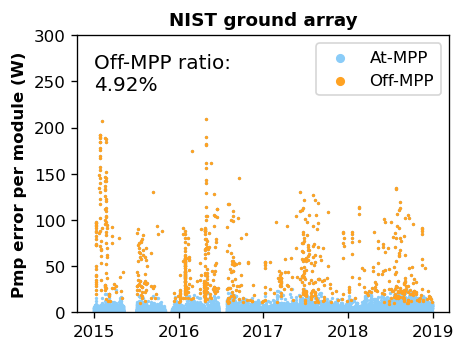

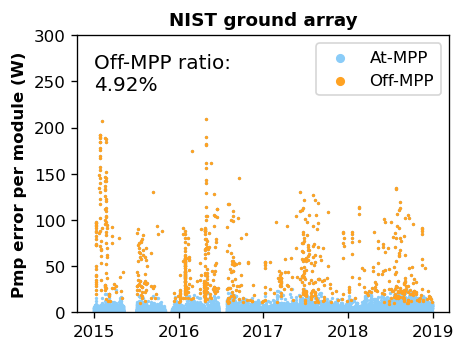

In [38]:
pvproplot.plot_Pmp_error_vs_time(pvp, boolean_mask_test, sys_name = 'NIST ground array')


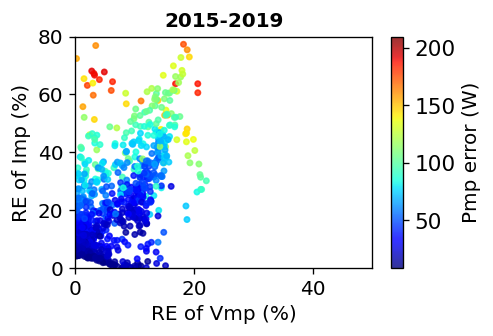

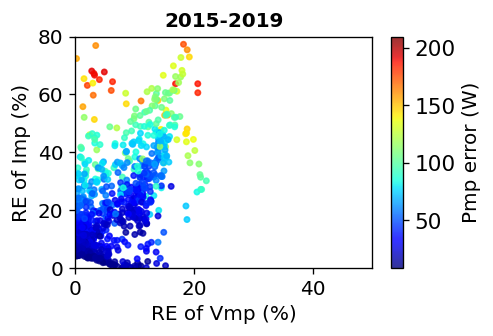

In [39]:
pvproplot.plot_Vmp_Imp_scatters_Pmp_error(pvp, boolean_mask_test, sys_name = 'NIST ground array', 
                                        show_only_offmpp = True, date_show = '2015-2019')

### Inspect the startpoint

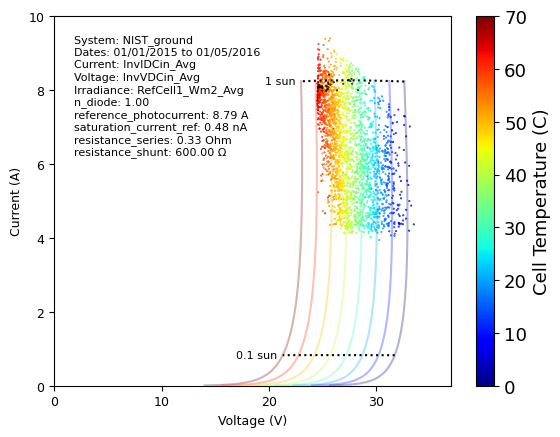

In [40]:
pvproplot.plot_Vmp_Imp_scatter(pvp,
        df=pvp.df[boolean_mask][:10000],
        p_plot=pvp.p0,
        plot_imp_max=10,
        plot_vmp_max=37)

In [41]:
hyperparams = {
    'use_voc_points': False,
    'use_mpp_points': True,
    'use_clip_points': False,
    'method': 'minimize',
    'solver': 'L-BFGS-B',
    'days_per_run': 14,
    'iterations_per_year': 26,
    'start_point_method': 'last',
    'saturation_current_multistart': [1],
    'verbose': False,
    'diode_factor': pvp.p0['diode_factor']
}

### Execute parameter extraction

In [42]:
fit_params = ['photocurrent_ref', 'saturation_current_ref',
                          'resistance_series_ref', 
                         'conductance_shunt_extra',
                         'resistance_shunt_ref', 
                          'diode_factor']
lower_bounds = dict(
            diode_factor=0.1,
            photocurrent_ref=0.01,
            saturation_current_ref=5e-12,
            resistance_series_ref=0.1,
            conductance_shunt_extra=0,
            resistance_shunt_ref=100
        )

upper_bounds = dict(
    diode_factor=1.5,
    photocurrent_ref=10,
    saturation_current_ref=1e-6,
    resistance_series_ref=2,
    conductance_shunt_extra=0,
    resistance_shunt_ref=1000
)
ret = pvp.execute(iteration='all', fit_params= fit_params,
                lower_bounds=lower_bounds,
                upper_bounds=upper_bounds,
                  **hyperparams,
                  boolean_mask = boolean_mask,
                  technology=technology) 

100%|██████████| 103/103 [00:04<00:00, 24.51it/s]

Elapsed time: 0.07 min


### Pull out the fitting results

In [43]:
pfit = pvp.result['p']

In [44]:
@interact
def inspect_results(k=(0,len(pfit),1),filter=True):

    cax = np.logical_and(
        pvp.df.index>pfit['t_start'][k],
        pvp.df.index<pfit['t_end'][k]
    )
    if filter:
        mask = boolean_mask[cax]
    else:
        mask = np.ones_like(boolean_mask[cax])
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    pvproplot.plot_Vmp_Imp_scatter(pvp, df=pvp.df[cax][mask],
                                p_plot=pfit.iloc[k],
                            plot_vmp_max=37,
                            plot_imp_max=10)
    plt.subplot(1,2,2)
    pvproplot.plot_current_irradiance_mpp_scatter(pvp, df=pvp.df[cax][mask],
                                        p_plot=pfit.iloc[k], plot_imp_max=10)
    plt.gcf().set_dpi(100)
    plt.show()

interactive(children=(IntSlider(value=51, description='k', max=103), Checkbox(value=True, description='filter'…

In [45]:
# Calculate YOY trend
yoy_result = pvp.analyze_yoy(pfit)

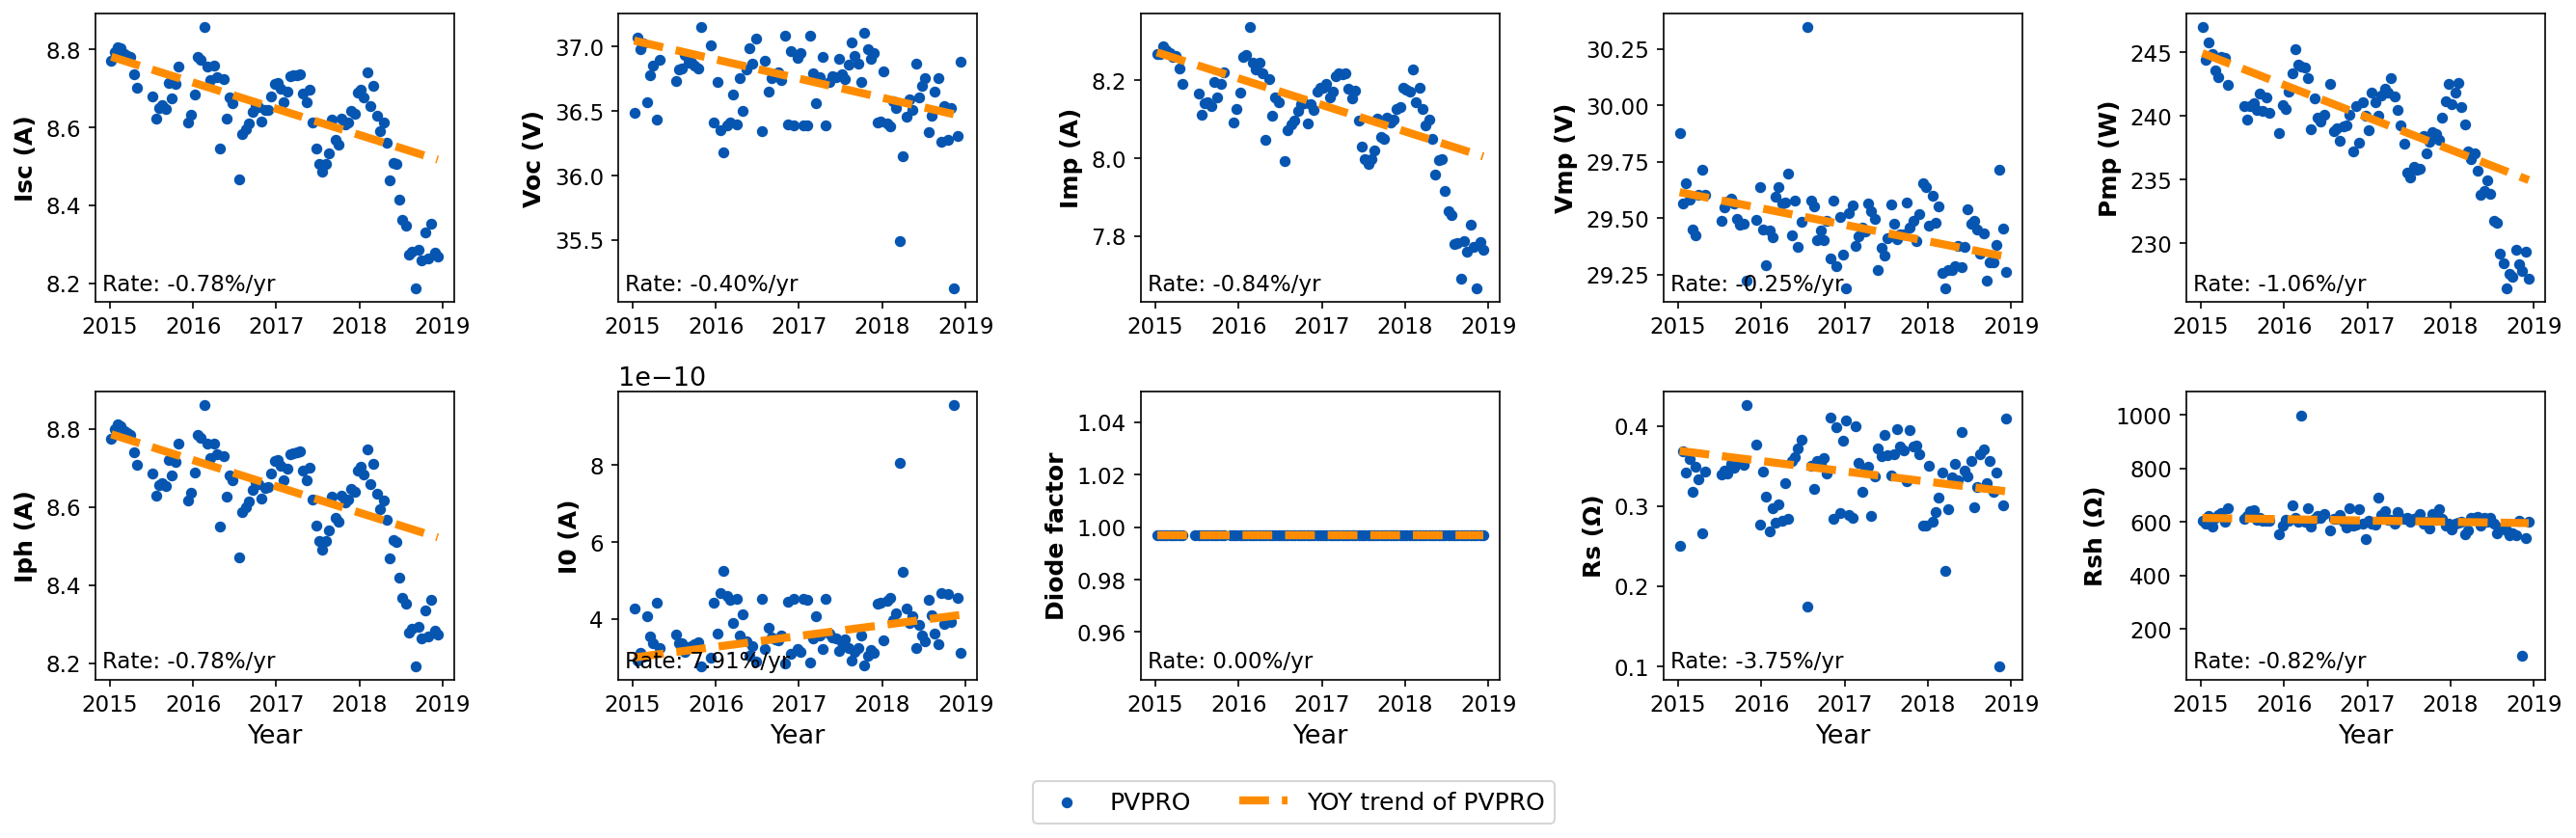

In [47]:
# Plot the evolution of extracted parameters
pvproplot.plot_results_timeseries_error(pfit, yoy_result = yoy_result, yoy_plot = True, xticks = range(2015,2020), legendloc  = [-0.3,-0.5])

# Post-processing of results

The post-processor formulates
a signal decomposition problem to estimate a “clean” trend of the PVPro parameter changes
over time, with noise and seasonality removed.

In [48]:
days_per_run = 14
period = 365/days_per_run
options = {'index_col': 0, 'dates': None, 'df_prep': True, 'include': None, 'exclude': None, 'verbose': True, 'bp': False}
post = PostProcessor(pfit, period, **options)

In [49]:
keys = ['i_mp_ref', 'photocurrent_ref', 'v_mp_ref', 'saturation_current_ref', 'i_sc_ref', 
        'v_oc_ref', 'resistance_series_ref', 'p_mp_ref', 'resistance_shunt_ref']
for key in keys:
    post.analyze(key)

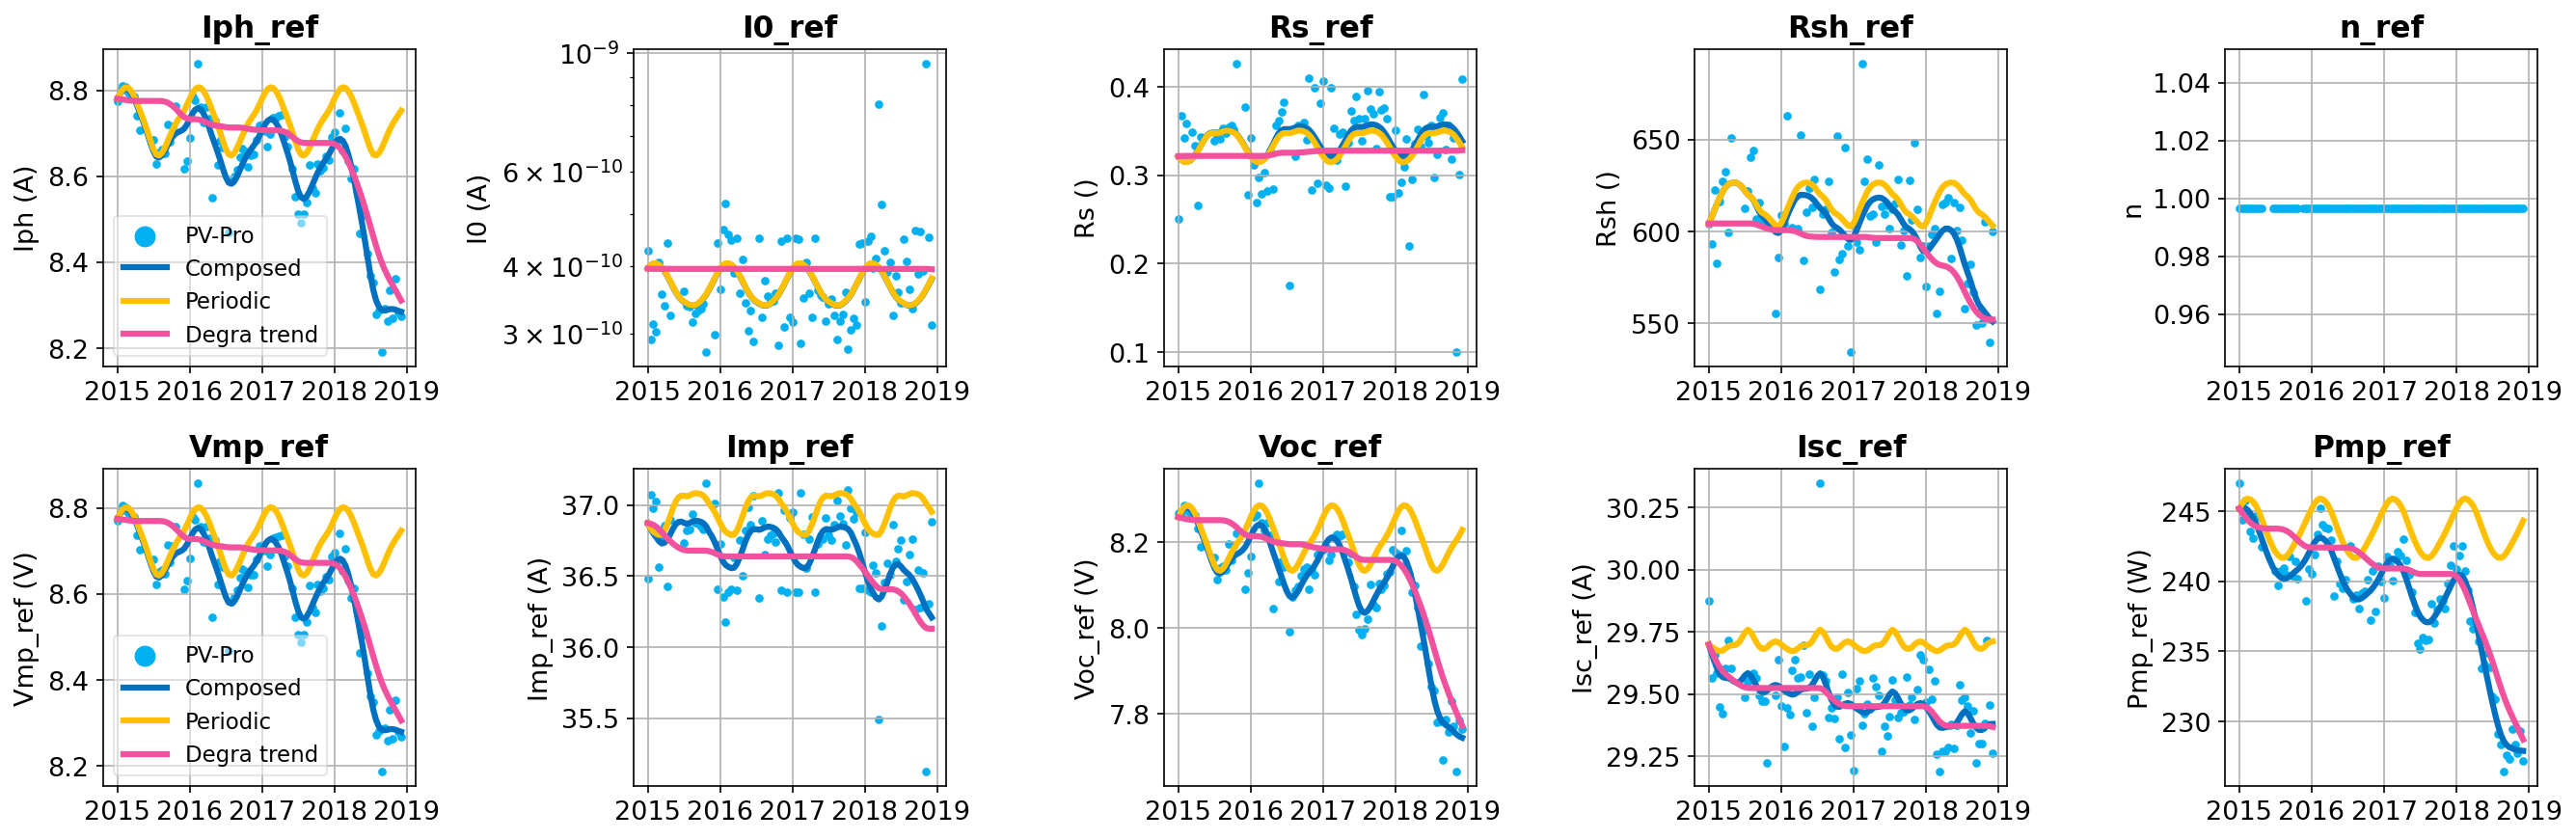

In [50]:
plot_post_processed_results(post)